In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

### Clean SwanHill weather data

In [3]:
def data_wrangling_weather(df, fill_missing='mean', drop_duplicates=True):
    # change data types
    df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0], errors='coerce')
    for col in df.columns[2:]:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # fill in missing values
    if fill_missing == 'mean':
        df.fillna(df.mean(numeric_only=True), inplace=True)
    elif fill_missing == 'median':
        df.fillna(df.median(numeric_only=True), inplace=True)
        
    # remove duplicates
    if drop_duplicates:
        df.drop_duplicates(inplace=True)

    return df

### Clean sensor data (3 datasets: simple, complex, time series)

In [4]:
def data_wrangling_sensor(df):
    df.dropna(how='all', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

### Normalize data by MinMax technique

In [5]:
def min_max_normalize(df, exclude_cols=None):
    if exclude_cols is None:
        exclude_cols = []

    numeric_cols = df.select_dtypes(include='number').columns.difference(exclude_cols)
    scaler = MinMaxScaler()
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    
    return df

### Normalize data by zScore technique

In [6]:
def z_score_standardize(df, exclude_cols=None):
    if exclude_cols is None:
        exclude_cols = []

    numeric_cols = df.select_dtypes(include='number').columns.difference(exclude_cols)
    scaler = StandardScaler()
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    return df

### Call this function in the main program

In [7]:
def normalize(df_cleaned, start_numeric_index, method='minmax'): # or 'zscore'

    # find data range for normalization
    datetime_col = df_cleaned.columns[0]
    numeric_cols = df_cleaned.columns[start_numeric_index:]  # everything after datetime is assumed numeric

    variable_cols = [col for col in numeric_cols if df_cleaned[col].nunique() > 1]
    
    # normalize
    if method == 'minmax':
        normalized_data = min_max_normalize(df_cleaned[variable_cols].copy())
    elif method == 'zscore':
        normalized_data = z_score_standardize(df_cleaned[variable_cols].copy())
    else:
        raise ValueError("method must be 'minmax' or 'zscore'")
    
    # recombine with other columns (not normalized data)
    df_result = pd.concat([df_cleaned.iloc[:, :start_numeric_index].reset_index(drop=True), 
                           normalized_data.reset_index(drop=True)], axis=1)
    
    return df_result


### Test with datasets

### SwanHill weather dataset

In [8]:
weather_df = pd.read_csv('swanHill_weather data.csv')

In [9]:
print(weather_df.head())

                created_at  entry_id  field1  field2  field3  field4  field5
0  2025-03-22 05:28:04 UTC   3249424      29      33     136    1009   12.85
1  2025-03-22 05:28:34 UTC   3249425      29      33     136    1009   12.92
2  2025-03-22 05:29:05 UTC   3249426      29      33     136    1009   12.81
3  2025-03-22 05:29:35 UTC   3249427      29      33     136    1009   12.85
4  2025-03-22 05:30:06 UTC   3249428      29      33     136    1009   12.85


In [10]:
print(weather_df.dtypes)

created_at     object
entry_id        int64
field1          int64
field2          int64
field3          int64
field4          int64
field5        float64
dtype: object


In [12]:
weather_cleaned = data_wrangling_weather(weather_df, fill_missing='mean')

In [13]:
weather_cleaned.head()

,created_at,entry_id,field1,field2,field3,field4,field5
0,2025-03-22 05:28:04+00:00,3249424,29,33,136,1009,12.85
1,2025-03-22 05:28:34+00:00,3249425,29,33,136,1009,12.92
2,2025-03-22 05:29:05+00:00,3249426,29,33,136,1009,12.81
3,2025-03-22 05:29:35+00:00,3249427,29,33,136,1009,12.85
4,2025-03-22 05:30:06+00:00,3249428,29,33,136,1009,12.85


In [14]:
print(weather_cleaned.dtypes)

created_at     object
entry_id        int64
field1          int64
field2          int64
field3          int64
field4          int64
field5        float64
dtype: object


In [15]:
start_numeric_index = 2

In [59]:
weather_normalized = normalize(weather_cleaned, start_numeric_index, method='zscore')

In [60]:
weather_normalized = normalize(weather_cleaned, start_numeric_index, method='minmax')

In [61]:
weather_normalized.head()

,created_at,entry_id,field1,field2,field3,field4,field5
0,2025-03-22 05:28:04+00:00,0.000000,1.0,1.0,1.0,1.0,0.50
1,2025-03-22 05:28:34+00:00,0.005025,1.0,1.0,1.0,1.0,0.85
2,2025-03-22 05:29:05+00:00,0.010050,1.0,1.0,1.0,1.0,0.30
3,2025-03-22 05:29:35+00:00,0.015075,1.0,1.0,1.0,1.0,0.50
4,2025-03-22 05:30:06+00:00,0.020101,1.0,1.0,1.0,1.0,0.50


### Time Series dataset (excel file)

In [19]:
sensor_df = pd.read_excel('Time series.xlsx')

In [20]:
sensor_df.head()

,Ignore,Clock Time,time,sensor 1,sensor 2,sensor 3,Unnamed: 6,"c(s1, s2)","c(s2, s3)","c(s1, s3)"
0,0.00,00:00:00,0,1.000000,2.00000,0.700000,NaN,NaN,NaN,NaN
1,0.01,00:10:00,1,1.010000,1.99995,0.707000,NaN,w=15,NaN,NaN
2,0.02,00:20:00,2,1.019999,1.99980,0.713999,NaN,NaN,NaN,NaN
3,0.03,00:30:00,3,1.029996,1.99955,0.720997,NaN,NaN,NaN,NaN
4,0.04,00:40:00,4,1.039989,1.99920,0.727993,NaN,NaN,NaN,NaN


In [21]:
sensor_df = sensor_df.iloc[:, 1:6].copy()

In [22]:
sensor_cleaned = data_wrangling_sensor(sensor_df)

In [23]:
sensor_cleaned.head()

,Clock Time,time,sensor 1,sensor 2,sensor 3
0,00:00:00,0,1.000000,2.00000,0.700000
1,00:10:00,1,1.010000,1.99995,0.707000
2,00:20:00,2,1.019999,1.99980,0.713999
3,00:30:00,3,1.029996,1.99955,0.720997
4,00:40:00,4,1.039989,1.99920,0.727993


In [24]:
start_numeric_index = 1

In [25]:
sensor_normalized = normalize(sensor_cleaned, start_numeric_index, method='minmax')

In [26]:
sensor_normalized.head()

,Clock Time,time,sensor 1,sensor 2,sensor 3
0,00:00:00,0.000000,0.499999,1.000000,0.499999
1,00:10:00,0.000993,0.504999,0.999975,0.504999
2,00:20:00,0.001986,0.509999,0.999900,0.509999
3,00:30:00,0.002979,0.514997,0.999775,0.514997
4,00:40:00,0.003972,0.519994,0.999600,0.519994


### simple & complex datasets

In [27]:
simple_df = pd.read_csv('simple.csv')  #can replace by complex.csv

In [28]:
simple_df.head()

,time,s1,s2,s3
0,0,1.000000,2.00000,0.700000
1,1,1.010000,1.99995,0.707000
2,2,1.019999,1.99980,0.713999
3,3,1.029996,1.99955,0.720997
4,4,1.039989,1.99920,0.727993


In [29]:
simple_cleaned = data_wrangling_sensor(simple_df)

In [30]:
start_numeric_index = 1

In [31]:
simple_normalized = normalize(simple_cleaned, start_numeric_index, method='minmax')

In [32]:
simple_normalized.head()

,time,s1,s2,s3
0,0,0.499999,1.000000,0.499999
1,1,0.504999,0.999975,0.504999
2,2,0.509999,0.999900,0.509999
3,3,0.514997,0.999775,0.514997
4,4,0.519994,0.999600,0.519994


In [44]:
simple_normalized.columns = ['time', 's1', 's2', 's3']

### test diagrams (see normalized data distribution)

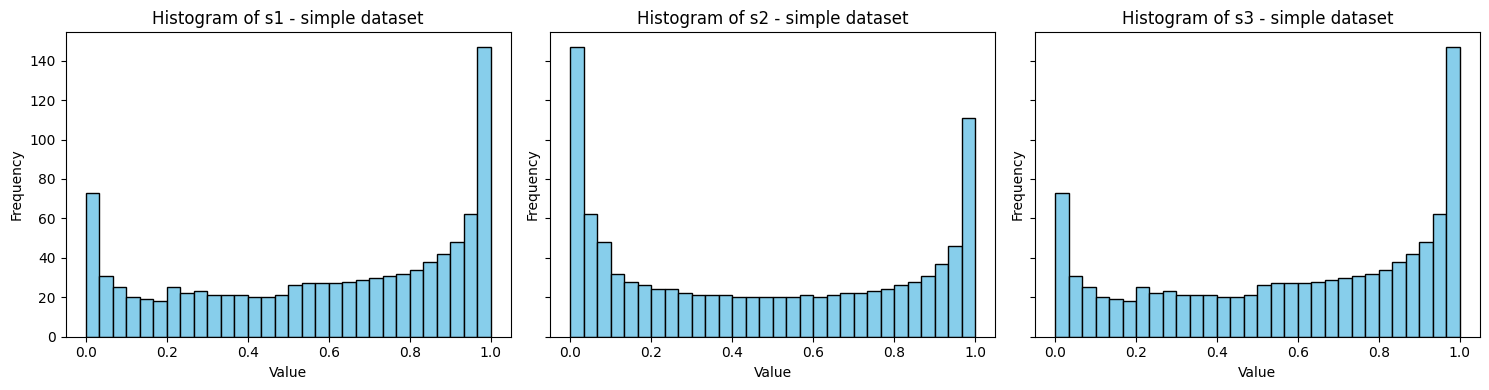

In [53]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

for index, col in enumerate(['s1', 's2', 's3']):
    axes[index].hist(simple_normalized[col], bins=30, color='skyblue', edgecolor='black')
    axes[index].set_title(f'Histogram of {col} - simple dataset')
    axes[index].set_xlabel('Value')
    axes[index].set_ylabel('Frequency')

plt.tight_layout()
plt.show()